In [53]:
# ===== 📦 Cell 1: Install Required Packages =====
# Use Colab's built-in Spark; install H2O, PySparkling, and dependencies
!pip install -q h2o h2o_pysparkling_3.0 pyspark findspark pandas matplotlib scikit-learn shap

In [54]:

# ===== 🚀 Cell 2: Initialize Findspark, SparkSession, and H2OContext =====
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pysparkling import H2OContext
import h2o

# Create Spark session
spark = SparkSession.builder \
    .appName("ReadmissionPredictionSparklingWater") \
    .master("local[*]") \
    .getOrCreate()
# Initialize H2OContext
hc = H2OContext.getOrCreate()

In [63]:
# ===== 📂 Cell 3: Load Preprocessed Data into Pandas =====
import pandas as pd
# Ensure files are present
import os
if not os.path.exists('/content/train_preprocessed.csv') or not os.path.exists('/content/test_preprocessed.csv'):
    raise FileNotFoundError("Preprocessed CSV files not found in /content. Please upload train_preprocessed.csv and test_preprocessed.csv")
# Read via pandas
train_pd = pd.read_csv('/content/train_preprocessed.csv')
test_pd  = pd.read_csv('/content/test_preprocessed.csv')

In [64]:
# ===== 🔄 Cell 4: Convert Pandas to H2OFrame & Preprocess =====
from h2o import H2OFrame
# Initialize H2OFrame directly from pandas
train_hf = H2OFrame(train_pd)
test_hf  = H2OFrame(test_pd)
# Convert target column to factor for classification
train_hf['readmit_30_days'] = train_hf['readmit_30_days'].asfactor()
test_hf['readmit_30_days']  = test_hf['readmit_30_days'].asfactor()

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [65]:
# ===== ✂️ Cell 5: Split Train into Train/Validation =====
train_split, valid_split = train_hf.split_frame(ratios=[0.85], seed=42)

In [66]:
# ===== 🎯 Cell 6: Define Features & Target =====
features = [c for c in train_hf.columns if c.startswith("PC")]  # PCA features
target   = "readmit_30_days"

In [67]:
# ===== 🤖 Cell 7: Train GLM, GBM, RF =====
from h2o.estimators import H2OGeneralizedLinearEstimator, H2OGradientBoostingEstimator, H2ORandomForestEstimator
# Train models
glm = H2OGeneralizedLinearEstimator(family='binomial', lambda_=0.1, alpha=0.5)
glm.train(x=features, y=target, training_frame=train_split)
gbm = H2OGradientBoostingEstimator(ntrees=100, max_depth=5, learn_rate=0.1, seed=42)
gbm.train(x=features, y=target, training_frame=train_split, validation_frame=valid_split)
rf = H2ORandomForestEstimator(ntrees=100, max_depth=20, seed=42)
rf.train(x=features, y=target, training_frame=train_split)

# Evaluate models
for name, model in [("GLM", glm), ("GBM", gbm), ("RF", rf)]:
    perf = model.model_performance(test_data=test_hf)
    print(f"{name} AUC: {perf.auc():.4f}")

glm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%
GLM AUC: 0.6063
GBM AUC: 0.6818
RF AUC: 0.9859


contributions progress: |████████████████████████████████████████████████████████| (done) 100%


Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)



        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.363915  0.016072  0.031385  0.036841 -0.021972 -0.211776 -0.061781   
1  0.125142  0.023708  0.031680  0.074792  0.023519 -0.020826  0.030929   
2 -0.234952  0.010399  0.005153 -0.154391  0.007100  0.002801 -0.005659   
3 -0.273627  0.015204 -0.003640  0.094755 -0.021829 -0.007485 -0.000967   
4  0.351524  0.019766  0.003966 -0.068521 -0.031132  0.039984  0.017026   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0 -0.002687 -0.056142 -0.500521  0.008723  0.001585 -0.048630 -0.081946   
1  0.016870 -0.062492 -0.026231 -0.063142 -0.090869  0.069900  0.015846   
2  0.009630  0.002039 -0.004032  0.003846 -0.023009  0.082910  0.001119   
3  0.016763  0.008082  0.013067 -0.002856 -0.025443  0.002832  0.004552   
4  0.029839 -0.000592  0.009669 -0.004543  0.051671 -0.042692  0.003872   

       PC15      PC16      PC17      PC18  BiasTerm  
0  0.022540 -0.002539 -0.042890  0.036000  0

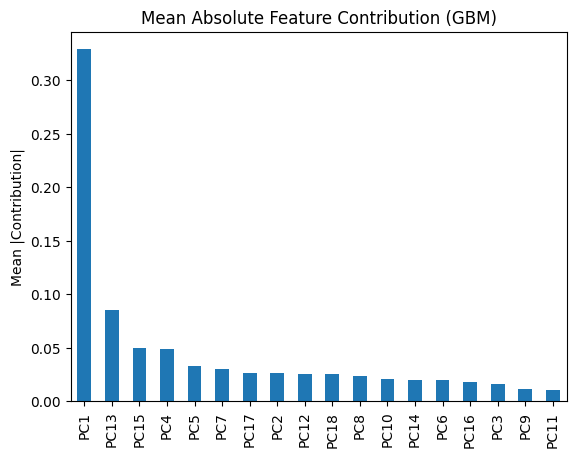

In [70]:
# ===== ⚡ Cell 8: H2O Model Feature Contributions =====
# Use H2O's built-in contributions for GBM (SHAP values equivalent)
# Predict contributions on test H2OFrame
df_contrib = gbm.predict_contributions(test_hf).as_data_frame()
# Show first few contribution values
print(df_contrib.head())

# Plot mean absolute contribution per feature
import matplotlib.pyplot as plt
import pandas as pd
# Exclude the bias column 'BiasTerm' if present
contrib_features = [c for c in df_contrib.columns if c in features]
mean_abs = df_contrib[contrib_features].abs().mean().sort_values(ascending=False)
mean_abs.plot(kind='bar', title='Mean Absolute Feature Contribution (GBM)')
plt.ylabel('Mean |Contribution|')
plt.show()

In [71]:
# ===== 🧯 Cell 9: Stop H2O and Spark =====: Stop H2O and Spark =====: Stop H2O and Spark =====
hc.stop()
spark.stop()

H2O session _sid_a711 closed.


In [2]:
!pip install h2o

   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.0/265.9 MB ? eta -:--:--
   ---------------------------------------- 0.5/265.9 MB 1.5 MB/s eta 0:02:55
   ---------------------------------------- 0.8/265.9 MB 1.5 MB/s eta 0:02:54
   ---------------------------------------- 1.0/265.9 MB 1.6 MB/s eta 0:02:44
   ---------------------------------------- 1.6/265.9 MB 1.8 MB/s eta 0:02:25
   ---------------------------------------- 2.4/265.9 MB 2.1 MB/s eta 0:02:04
   ---------------------------------------- 2.9/265.9 MB 2.2 MB/s eta 0:02:00
    --------------------------------------- 3.4/265.9 MB 2.3 MB/s eta 0:01:54
    --------------------------------------- 4.2/265.9 MB 2.5 MB/s eta 0:01:45
    --------------------------------------- 4.5/265.9 MB 2.4 MB/s eta 0:01:52
    --------------------------------------- 5.5/265.9 MB 2.6 MB/s eta 0:01:39
    ---

In [3]:
# %%
# Cell 1: Imports and H2O initialization
import h2o
from h2o.exceptions import H2OConnectionError
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    precision_recall_curve
)

# Initialize H2O
try:
    h2o.init(max_mem_size="4G")
except H2OConnectionError:
    h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
; OpenJDK 64-Bit Server VM Temurin-11.0.27+6 (build 11.0.27+6, mixed mode)
  Starting server from C:\Users\dorai\anaconda3\Lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\dorai\AppData\Local\Temp\tmphq2tfnr3
  JVM stdout: C:\Users\dorai\AppData\Local\Temp\tmphq2tfnr3\h2o_dorai_started_from_python.out
  JVM stderr: C:\Users\dorai\AppData\Local\Temp\tmphq2tfnr3\h2o_dorai_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,Asia/Kolkata
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,1 month and 10 days
H2O_cluster_name:,H2O_from_python_dorai_ze54gh
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [7]:
# Cell 2: Load trained H2O models (update paths if needed)
import os
from h2o.exceptions import H2OResponseError

# Define model paths
model_paths = {
    'DRF': r'C:\\Users\\dorai\\OneDrive\\Documents\\Documents\\SEM6\\BigData\\PROJECT\\output\\H2O_sparklingwater_models\\DRF_model_python_1746621832227_39',
    'GBM': r'C:\\Users\\dorai\\OneDrive\\Documents\\Documents\\SEM6\\BigData\\PROJECT\\output\\H2O_sparklingwater_models\\GBM_model_python_1746621832227_4',
    'GLM': r'C:\\Users\\dorai\\OneDrive\\Documents\\Documents\\SEM6\\BigData\\PROJECT\\output\\H2O_sparklingwater_models\\GLM_model_python_1746621832227_1'
}

models = {}
for name, path in model_paths.items():
    # Check if path exists in this environment
    if not os.path.exists(path):
        raise FileNotFoundError(f'Model path not found: {path}')
    try:
        models[name] = h2o.load_model(path)
        print(f'Successfully loaded {name} from {path}')
    except H2OResponseError as e:
        print(f'Error loading {name} from {path}: {e}')
        raise

# %%

Successfully loaded DRF from C:\\Users\\dorai\\OneDrive\\Documents\\Documents\\SEM6\\BigData\\PROJECT\\output\\H2O_sparklingwater_models\\DRF_model_python_1746621832227_39
Successfully loaded GBM from C:\\Users\\dorai\\OneDrive\\Documents\\Documents\\SEM6\\BigData\\PROJECT\\output\\H2O_sparklingwater_models\\GBM_model_python_1746621832227_4
Successfully loaded GLM from C:\\Users\\dorai\\OneDrive\\Documents\\Documents\\SEM6\\BigData\\PROJECT\\output\\H2O_sparklingwater_models\\GLM_model_python_1746621832227_1


In [9]:
# %%
# Cell 3: Import the test dataset and preview
test_path = r"C:\\Users\\dorai\\OneDrive\\Documents\\Documents\\SEM6\\BigData\\PROJECT\\data\\test_preprocessed.csv"
test_hf = h2o.import_file(test_path)
print("Test data preview:")
print(test_hf.head())

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Test data preview:
       PC1        PC2        PC3          PC4        PC5          PC6        PC7         PC8         PC9        PC10       PC11        PC12       PC13        PC14       PC15        PC16         PC17       PC18    readmit_30_days
 2.64798     1.16082   -1.87979   -0.995661    -0.77191   -2.46436     -1.38814   -0.313003   -1.66463    -2.6168      0.897356   0.0574446   0.461668   0.773975   -0.213215   1.00921    -1.216        0.598965                  0
 0.0149717   1.09437   -1.01087   -1.20156      1.10366   -1.62038      1.08839   -0.327848   -1.24525    -0.549546    1.62712    0.301144    0.164105  -0.3652     -0.602793  -0.526281   -1.11562     -1.50172                   0
-1.14726     0.568243  -0.718272   2.5218       0.724584   0.318093    -0.326662   0.128518   -0.299055   -0.698829   -1.46107   -0.259334   -0.350538  -0.27888     0.687343  -1.70131    -0.256377   

In [13]:
# %%
# %%
# Cell 4: Specify target and feature columns
# Set the actual target column from test data
TARGET = 'readmit_30_days'
# Validate that the target exists
if TARGET not in test_hf.columns:
    raise ValueError(
        f"Target column '{TARGET}' not found in test data."
        f"Available columns: {test_hf.columns}"
        "Please check the column name."
    )
FEATURES = [col for col in test_hf.columns if col != TARGET]
print(f"Using target: {TARGET}")
print(f"Feature count: {len(FEATURES)}")

Using target: readmit_30_days
Feature count: 18



=== Evaluating DRF Model ===
drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%

Classification Report:


c:\Users\dorai\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


              precision    recall  f1-score   support

           0       0.95      0.93      0.94     26425
           1       0.94      0.95      0.94     26501

    accuracy                           0.94     52926
   macro avg       0.94      0.94      0.94     52926
weighted avg       0.94      0.94      0.94     52926



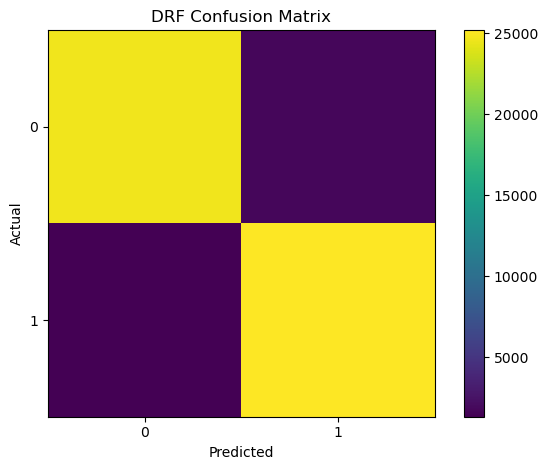

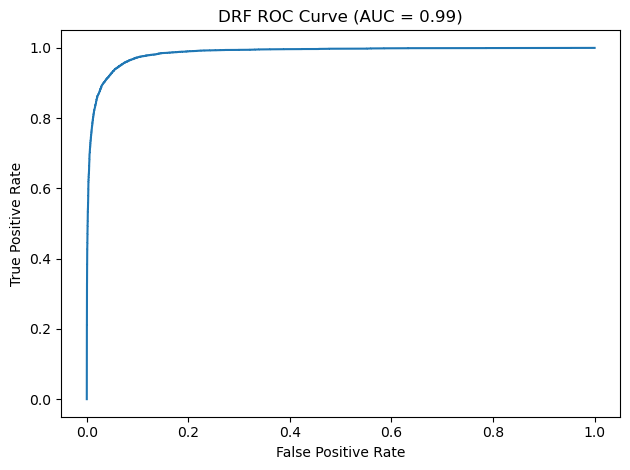

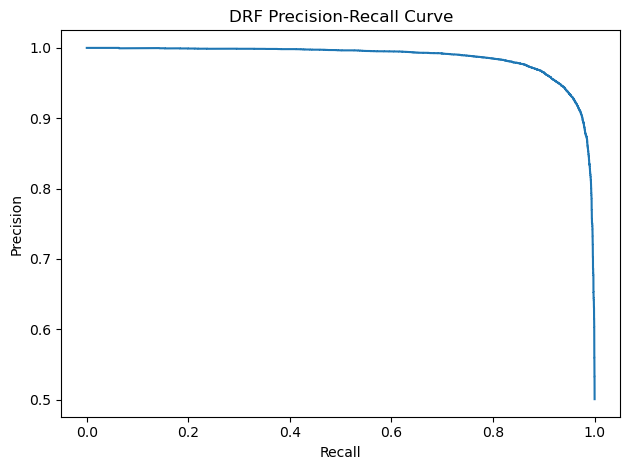


=== Evaluating GBM Model ===
gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.31      0.44     26425
           1       0.56      0.89      0.69     26501

    accuracy                           0.60     52926
   macro avg       0.65      0.60      0.56     52926
weighted avg       0.65      0.60      0.56     52926



c:\Users\dorai\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\dorai\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


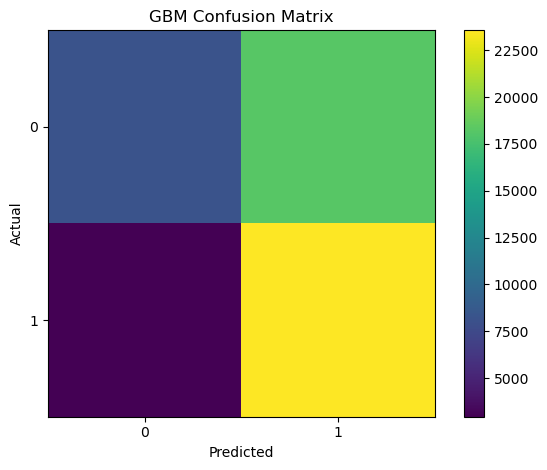

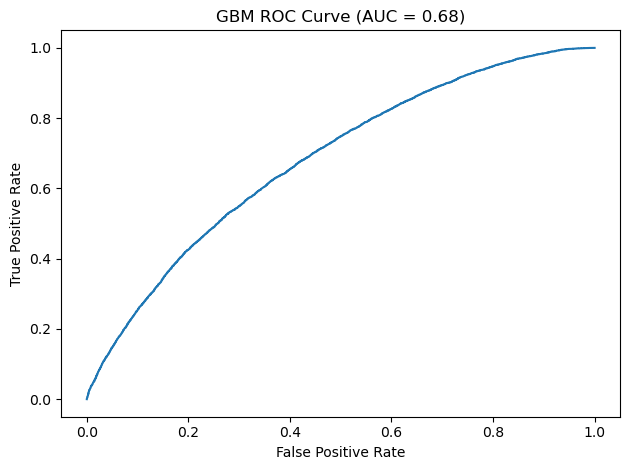

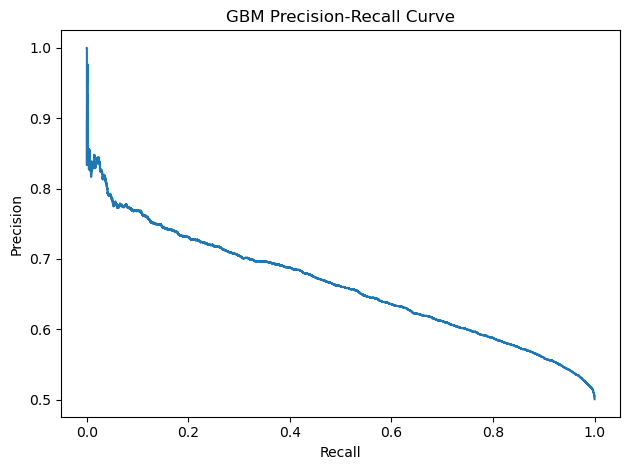


=== Evaluating GLM Model ===
glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.03      0.05     26425
           1       0.51      0.99      0.67     26501

    accuracy                           0.51     52926
   macro avg       0.64      0.51      0.36     52926
weighted avg       0.64      0.51      0.36     52926



c:\Users\dorai\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
c:\Users\dorai\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


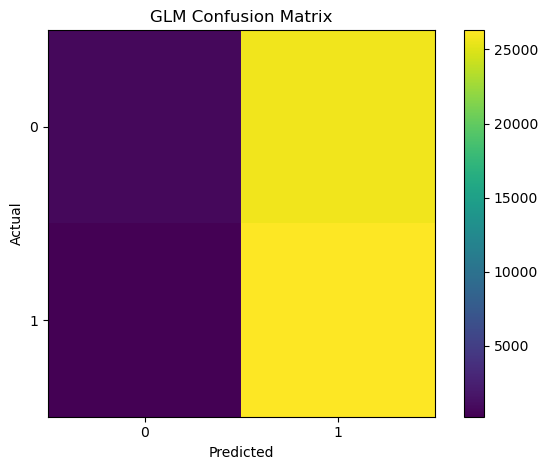

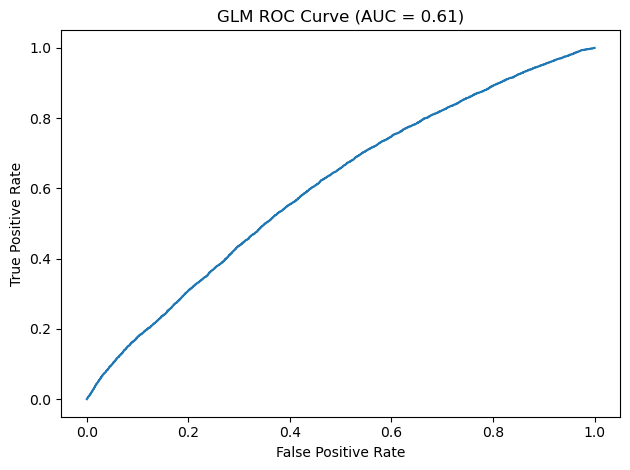

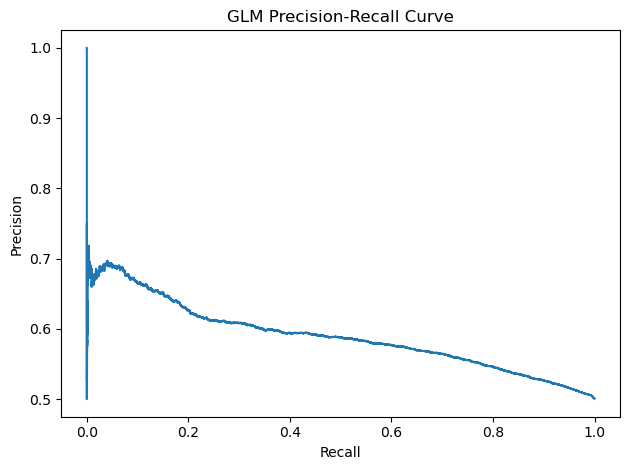

In [14]:
# %%
# Cell 5: Evaluate each model with metrics and plots
for name, model in models.items():
    print(f"\n=== Evaluating {name} Model ===")
    
    # 1) Generate predictions
    pred_hf = model.predict(test_hf[FEATURES])
    pred_df = pred_hf.as_data_frame()
    
    # 2) Extract true labels, predicted labels, and probabilities
    y_true = test_hf[TARGET].as_data_frame().values.ravel()
    y_pred = pred_df['predict'].values
    prob_cols = [c for c in pred_df.columns if c.startswith('p')]
    y_prob = pred_df[prob_cols[-1]].values
    
    # 3) Classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # 4) Confusion matrix plot
    cm = confusion_matrix(y_true, y_pred)
    plt.figure()
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.colorbar()
    plt.xticks(range(len(cm)))
    plt.yticks(range(len(cm)))
    plt.tight_layout()
    plt.show()
    
    # 5) ROC curve
    auc_score = roc_auc_score(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title(f"{name} ROC Curve (AUC = {auc_score:.2f})")
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.tight_layout()
    plt.show()
    
    # 6) Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_prob)
    plt.figure()
    plt.plot(recall, precision)
    plt.title(f"{name} Precision-Recall Curve")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.tight_layout()
    plt.show()


c:\Users\dorai\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


=== SHAP Analysis for DRF Model ===
contributions progress: |████████████████████████████████████████████████████████| (done) 100%


c:\Users\dorai\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


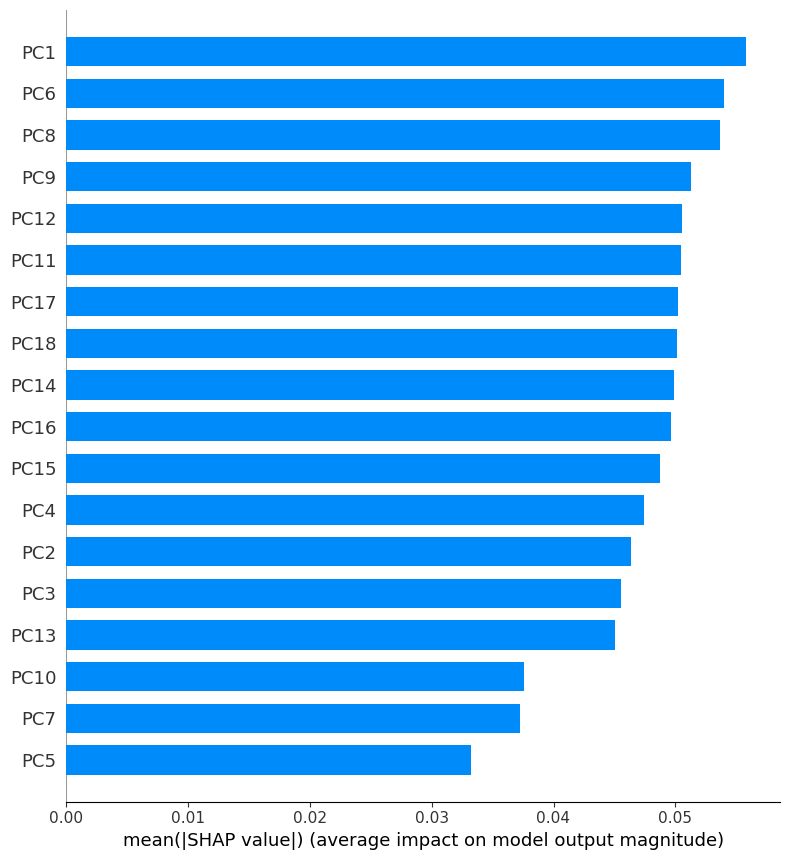

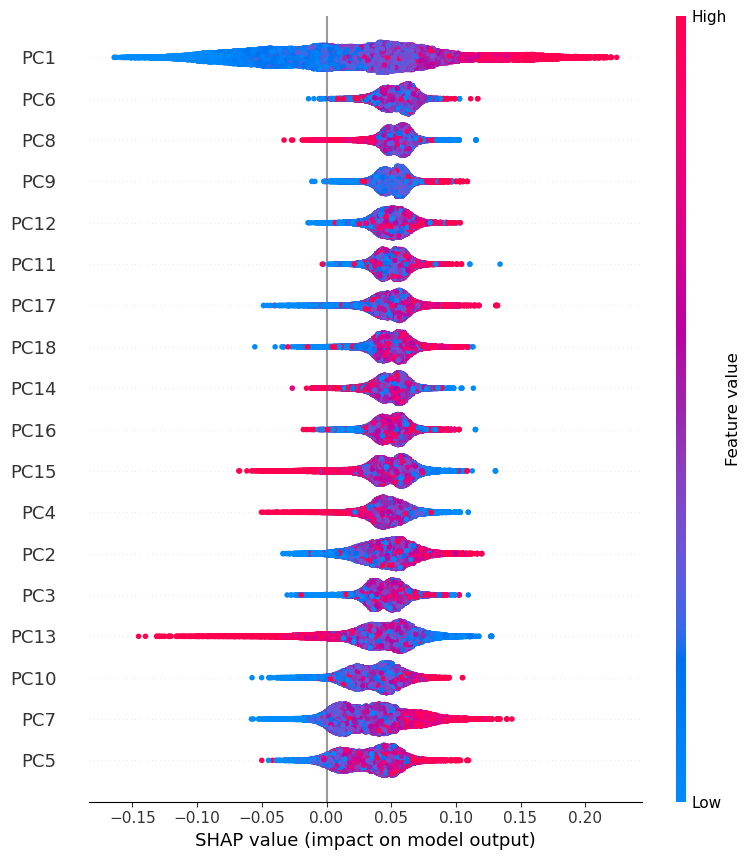

=== SHAP Analysis for GBM Model ===
contributions progress: |████████████████████████████████████████████████████████| (done) 100%


c:\Users\dorai\anaconda3\Lib\site-packages\h2o\frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


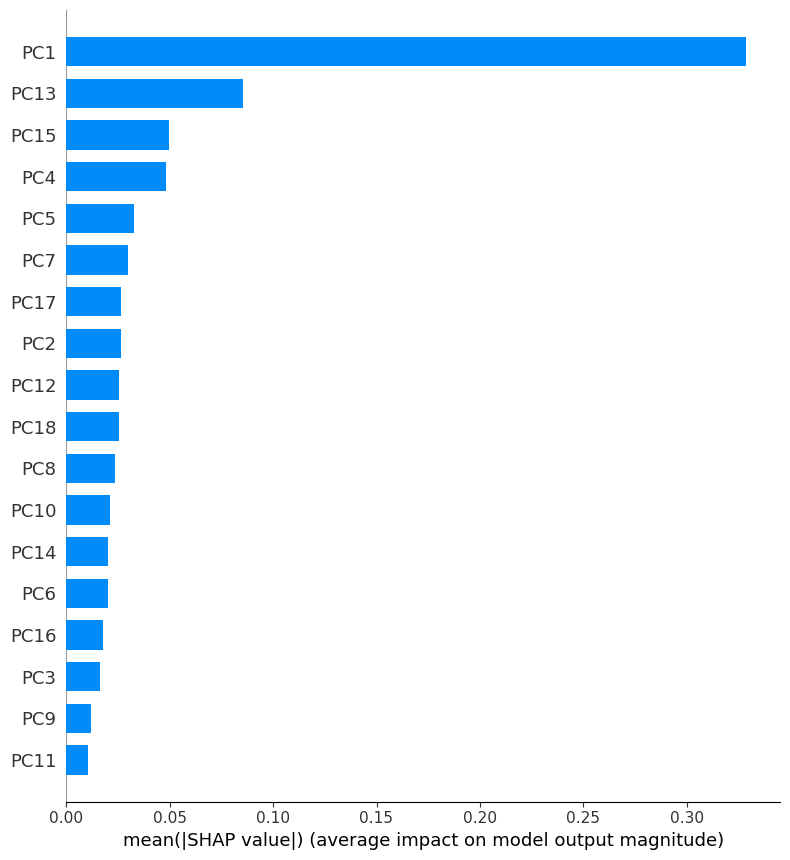

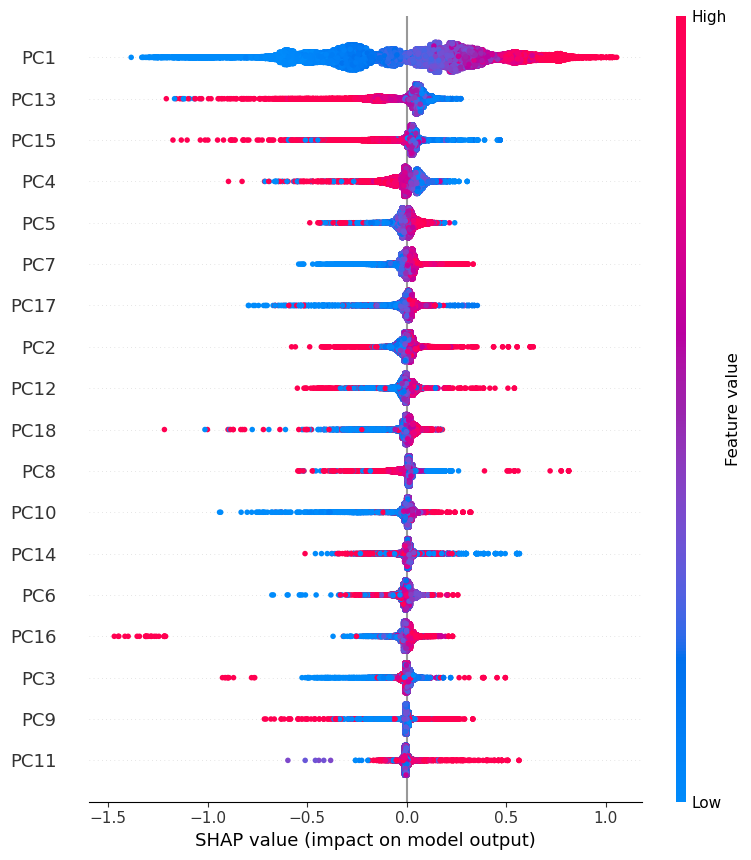

=== SHAP Analysis for GLM Model ===
contributions progress: | (failed)


OSError: Job with key $03017f00000132d4ffffffff$_bfb119466c0ee6a86cadfe2130884672 failed with an exception: water.exceptions.H2OIllegalArgumentException: unimplemented: GLM supports contribution calculation only with a background frame.
stacktrace: 
water.exceptions.H2OIllegalArgumentException: unimplemented: GLM supports contribution calculation only with a background frame.
	at water.H2O.unimpl(H2O.java:1385)
	at hex.glm.GLMModel.scoreContributions(GLMModel.java:247)
	at water.api.ModelMetricsHandler$1.compute2(ModelMetricsHandler.java:549)
	at water.H2O$H2OCountedCompleter.compute(H2O.java:1704)
	at jsr166y.CountedCompleter.exec(CountedCompleter.java:468)
	at jsr166y.ForkJoinTask.doExec(ForkJoinTask.java:263)
	at jsr166y.ForkJoinPool$WorkQueue.runTask(ForkJoinPool.java:976)
	at jsr166y.ForkJoinPool.runWorker(ForkJoinPool.java:1479)
	at jsr166y.ForkJoinWorkerThread.run(ForkJoinWorkerThread.java:104)


In [15]:
# %%
# Cell 6: SHAP Analysis using H2O contributions
import shap
# Convert H2O test frame to pandas for SHAP
X_pd = test_hf[FEATURES].as_data_frame()

for name, model in models.items():
    print(f"=== SHAP Analysis for {name} Model ===")
    # Obtain contribution frame (includes bias term and feature contributions)
    contrib_hf = model.predict_contributions(test_hf[FEATURES])
    contrib_df = contrib_hf.as_data_frame()
    # Drop the bias column (named 'BiasTerm') for SHAP plotting
    if 'BiasTerm' in contrib_df.columns:
        contrib_vals = contrib_df.drop(columns=['BiasTerm']).values
    else:
        contrib_vals = contrib_df.values
    # Summary plot of mean absolute SHAP values
    shap.summary_plot(contrib_vals, X_pd, feature_names=FEATURES, plot_type='bar')
    # Detailed summary plot
    shap.summary_plot(contrib_vals, X_pd, feature_names=FEATURES)

# %%
# Cell 7: (Optional) Dependence plots for top features
# Generate dependence plots for the top 3 features by mean absolute SHAP
import numpy as np
# Compute mean abs contributions across all models' first tree-based model
base_contrib = models['DRF'].predict_contributions(test_hf[FEATURES]).as_data_frame().drop(columns=['BiasTerm'])
mean_imp = base_contrib.abs().mean().sort_values(ascending=False)
top_feats = mean_imp.index[:3].tolist()

for feat in top_feats:
    print(f"Dependence plot for feature: {feat}")
    shap.dependence_plot(feat, contrib_vals, X_pd, feature_names=FEATURES)
